In [1]:
import os
import numpy as np

import pyedflib

In [2]:
import pandas as pd

In [3]:
import json

In [4]:
import matplotlib.pyplot as plt

In [5]:
data_set = set([it.replace(".json", "") for it in os.listdir("ecg_data") if it.endswith('.json')]) & set([it.replace(".edf", "") for it in os.listdir("ecg_data") if it.endswith('.edf')])
# data_list = [os.path.join("ecg_data", it) for it in data_set]
# edf_file_list

In [6]:
data_dict = dict()
for key in data_set:
    data_dict[key] = dict()
    data_dict[key]['json_path'] = os.path.join("ecg_data",key + ".json")
    data_dict[key]['edf_path'] = os.path.join("ecg_data",key + ".edf")

In [7]:
df_targets = pd.DataFrame()
for patient in data_dict:
    df_buffer = pd.DataFrame(pd.read_json(open(data_dict[patient]['json_path']),orient='columns',
                           typ='series', dtype=False))
    df_buffer = df_buffer.T
    df_buffer['patient'] = patient
    df_targets = df_targets.append(df_buffer.set_index('patient'))

In [8]:
df_numeric_targets = df_targets.applymap(lambda x: int(x))

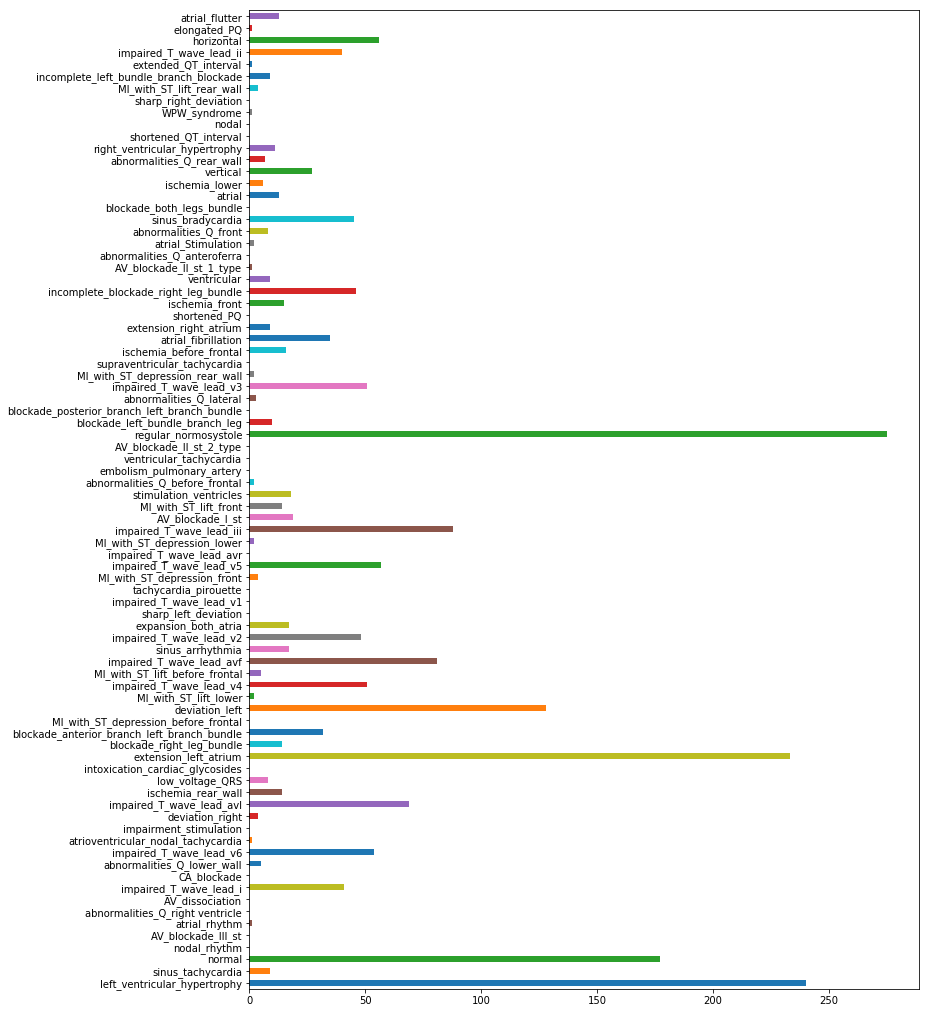

In [9]:
plt.figure(figsize=(12, 18))
df_numeric_targets.sum(axis=0).plot.barh()
pass

In [10]:
print("Количество пересекающихся диагнозов: {0}".format(len(df_numeric_targets.columns)))

Количество пересекающихся диагнозов: 82


In [11]:
print("Количество пациентов без какого-либо диагноза: {0}".format(df_numeric_targets[df_numeric_targets.sum(axis=1)<1].shape[0]))

Количество пациентов без какого-либо диагноза: 0


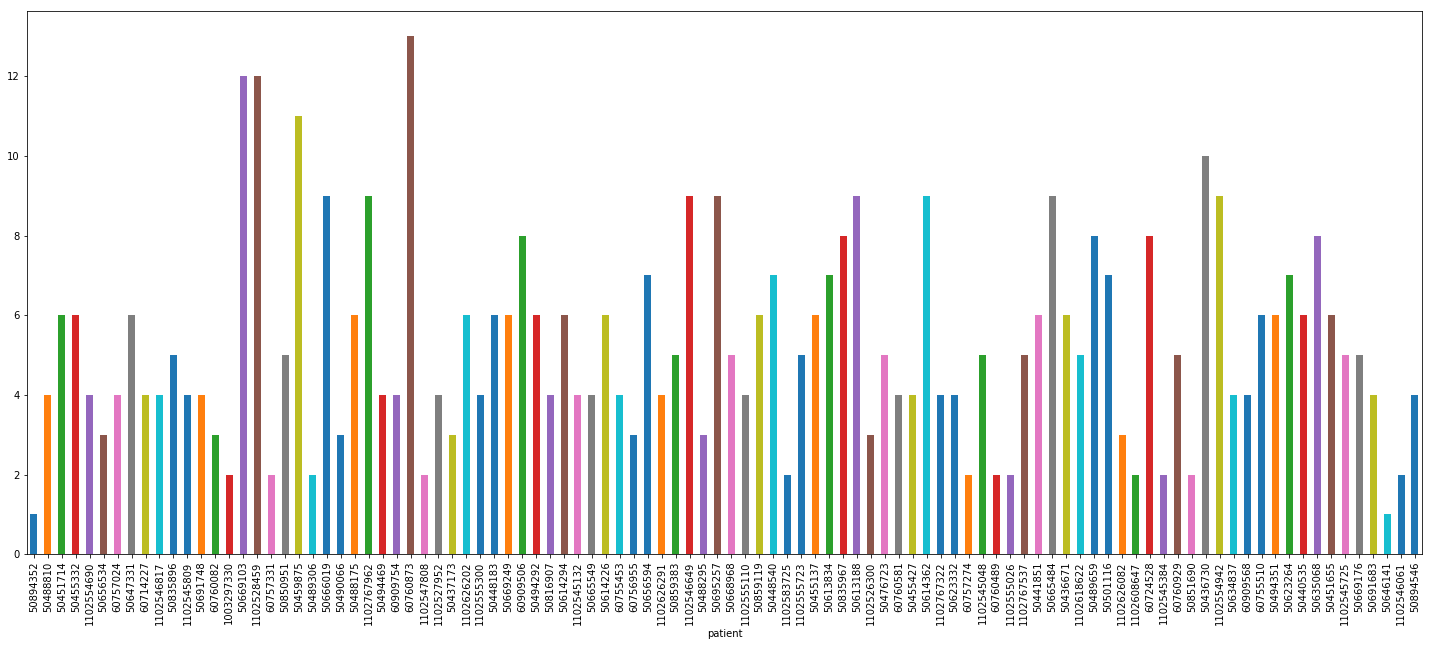

In [12]:
plt.figure(figsize=(25, 10))
df_numeric_targets.iloc[:100].sum(axis=1).plot.bar()

# Теперь давайте посмотрим на диагнозы более верхнеуровнево


---




In [14]:
diagnosis_dict_list = json.load(open("ecg_data/diagnosis.json", encoding='utf8'))

In [15]:
print("Количество категорий диагнозов: {0}".format(len([it['type'] for it in diagnosis_dict_list if it['type']=='category'])))

Количество категорий диагнозов: 12


In [16]:
[it.update({'1st_level_category':'PQ_characteristics',
            '1st_level_cat_desc':'P-Q особенности',
            '2nd_level_category':'PQ_characteristics',
            '2nd_level_cat_desc':'P-Q особенности'}) for it in diagnosis_dict_list if it['type']!='category']
print("Не категориальные диагнозы категоризуем вручную:")
[it for it in diagnosis_dict_list if it['type']!='category']

Не категориальные диагнозы категоризуем вручную:


[{'name': 'shortened_PQ',
  'type': 'diagnosis',
  'value': 'Укороченный P-Q',
  'level': 'yellow',
  '1st_level_category': 'PQ_characteristics',
  '1st_level_cat_desc': 'P-Q особенности',
  '2nd_level_category': 'PQ_characteristics',
  '2nd_level_cat_desc': 'P-Q особенности'},
 {'name': 'elongated_PQ',
  'type': 'diagnosis',
  'value': 'Удлиненный P-Q',
  'level': 'yellow',
  '1st_level_category': 'PQ_characteristics',
  '1st_level_cat_desc': 'P-Q особенности',
  '2nd_level_category': 'PQ_characteristics',
  '2nd_level_cat_desc': 'P-Q особенности'}]

## Приведем два уровня иерархии категорий для каждого диагноза

In [17]:
categorised_diagnosis_dict = dict()
for cat_dict in [it for it in diagnosis_dict_list]:
    if cat_dict['type'] != 'diagnosis':
        for diagnose_dict in cat_dict['value']:
            if diagnose_dict['type']!='diagnosis':
                for _sub_dict in diagnose_dict['value']:
                    _dict = dict()
                    _dict['1st_level_category'] = cat_dict['name']
                    _dict['1st_level_cat_desc'] = cat_dict['description']
                    _dict['2nd_level_category'] = diagnose_dict['name']
                    _dict['2nd_level_cat_desc'] = diagnose_dict['description']
                    _dict['alert_level'] = _sub_dict['level']
                    _dict['diagnose_desc'] = _sub_dict['value']
                    categorised_diagnosis_dict[_sub_dict['name']] = _dict
            else:
                _dict = dict()
                _dict['1st_level_category'] = cat_dict['name']
                _dict['1st_level_cat_desc'] = cat_dict['description']
                _dict['2nd_level_category'] = cat_dict['name']
                _dict['2nd_level_cat_desc'] = cat_dict['description']
                _dict['alert_level'] = diagnose_dict['level']
                _dict['diagnose_desc'] = diagnose_dict['value']
                categorised_diagnosis_dict[diagnose_dict['name']] = _dict
    else:
        _dict = dict()
        _dict['1st_level_category'] = cat_dict['1st_level_category']
        _dict['1st_level_cat_desc'] = cat_dict['1st_level_cat_desc']
        _dict['2nd_level_category'] = cat_dict['2nd_level_category']
        _dict['2nd_level_cat_desc'] = cat_dict['2nd_level_cat_desc']
        _dict['alert_level'] = cat_dict['level']
        _dict['diagnose_desc'] = cat_dict['value']
        categorised_diagnosis_dict[cat_dict['name']] = _dict
    #     print(cat_dict)

In [18]:
# Проверим что разметили категории для всех диагнозов
set(categorised_diagnosis_dict.keys()) ^ set(df_numeric_targets.columns)

set()

## Имея маппинг диагнозов на категории, можем проанализировать распределение целевых значений по группам

In [19]:
target_set_1st_lvl = set([categorised_diagnosis_dict[it]['1st_level_category'] for it in categorised_diagnosis_dict])
target_set_2nd_lvl = set([categorised_diagnosis_dict[it]['2nd_level_category'] for it in categorised_diagnosis_dict])
target_set_color_lvl = set([categorised_diagnosis_dict[it]['alert_level'] for it in categorised_diagnosis_dict])

In [20]:
len(target_set_2nd_lvl)

17

In [21]:
df_categorised_targets_1st_level = pd.DataFrame(columns=list(target_set_1st_lvl) + ['patient'])
df_categorised_targets_2nd_level = pd.DataFrame(columns=list(target_set_2nd_lvl) + ['patient'])
df_categorised_targets_color_level = pd.DataFrame(columns=list(target_set_color_lvl) + ['patient'])
for patient in df_numeric_targets.index:
    patient_series = df_numeric_targets.loc[patient]
    #   print(patient, patient_series[patient_series > 0].index)
    _diagnosis_1st_lvl_list = [categorised_diagnosis_dict[it]['1st_level_category'] for it in patient_series[patient_series > 0].index]
    pattern_1st_lvl = [_it if _it[0] not in _diagnosis_1st_lvl_list else (_it[0], 1) for _it in 
                     [it for it in 
                      zip(df_categorised_targets_1st_level.columns, 
                          [0]*len(target_set_1st_lvl) + [patient])]
                    ]
    _diagnosis_2nd_lvl_list = [categorised_diagnosis_dict[it]['2nd_level_category'] for it in patient_series[patient_series > 0].index]
    pattern_2nd_lvl = [_it if _it[0] not in _diagnosis_2nd_lvl_list else (_it[0], 1) for _it in 
                     [it for it in 
                      zip(df_categorised_targets_2nd_level.columns, 
                          [0]*len(target_set_2nd_lvl) + [patient])]
                    ]

    _diagnosis_color_lvl_list = [categorised_diagnosis_dict[it]['alert_level'] for it in patient_series[patient_series > 0].index]
    pattern_color_lvl = [_it if _it[0] not in _diagnosis_color_lvl_list else (_it[0], 1) for _it in 
                     [it for it in 
                      zip(df_categorised_targets_color_level.columns, 
                          [0]*len(target_set_color_lvl) + [patient])]
                    ]
    df_categorised_targets_1st_level = df_categorised_targets_1st_level.append(dict(pattern_1st_lvl), ignore_index=True)
    df_categorised_targets_2nd_level = df_categorised_targets_2nd_level.append(dict(pattern_2nd_lvl), ignore_index=True)
    df_categorised_targets_color_level = df_categorised_targets_color_level.append(dict(pattern_color_lvl), ignore_index=True)
    #   print(pattern_1st_lvl)
    #   print(pattern_2nd_lvl)


    #   break

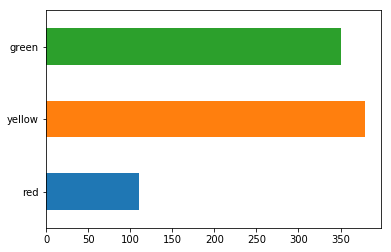

In [22]:
df_categorised_targets_color_level.set_index('patient').sum(axis=0).plot.barh()
plt.show()

In [23]:
df_categorised_targets_color_level.set_index('patient').head()

,red,yellow,green
patient,,,
50894352,0,1,0
50488810,0,1,1
50451714,1,1,1
50455332,1,1,1
1102554690,0,1,1


In [24]:
df_categorised_targets_color_level.set_index('patient').shape

(410, 3)

In [25]:
Y = df_categorised_targets_color_level.set_index('patient')

In [26]:
color_dataset_dict = dict()
for patient in Y.index:
    try:
        ecg_x = pyedflib.EdfReader("./ecg_data/{0}.edf".format(patient))
        sigbufs = np.zeros((ecg_x.signals_in_file, ecg_x.getNSamples()[0]))
        for i in np.arange(ecg_x.signals_in_file):
            sigbufs[i, :] = ecg_x.readSignal(i)
            color_dataset_dict[patient] = sigbufs
        ecg_x._close()
        del ecg_x
    except:
        print(patient)
#   print(sigbufs.shape)

1003297330


In [27]:
color_dataset_dict['1102625288'].shape

(12, 5000)

In [28]:
Y.loc['1102625288'].green

1

In [29]:
data_dict = dict()
for i in range(1):
    X_arr = np.zeros((len(color_dataset_dict.keys())*10,500))
    Y_arr = np.zeros((len(color_dataset_dict.keys())*10,1))
    j = 0
    for patient in color_dataset_dict.keys():
#         print(patient, Y.loc[patient].green)
        for it in range(500, 5000, 500):
            X_arr[j, :] = np.tanh(color_dataset_dict[patient][i][it-500:it])
            Y_arr[j,:] = Y.loc[patient].red
            j += 1
    data_dict["{0}-lead".format(i)] = (X_arr, Y_arr)


# easyesn

In [30]:
from easyesn import ClassificationESN

Using Numpy backend.


In [31]:
esn = ClassificationESN(n_input=1, n_reservoir=100, n_classes=1, spectralRadius=0.9, reservoirDensity=0.2,leakingRate=0.3)

In [32]:
esn.fit(*data_dict['0-lead'], verbose=1)

100% (4090 of 4090) |####################| Elapsed Time: 0:03:48 Time:  0:03:48


0.5445095297652703

In [33]:
y_hat = esn.predict(data_dict['0-lead'][0])

In [34]:
acc = np.mean([int(target[0] == hat[0]) for target, hat in zip(data_dict['0-lead'][1], y_hat)])

In [35]:
"Accuracy: {0}".format(acc) + " -- Точность на бинарной классификации, OMG"

'Accuracy: 0.24205378973105135 -- Точность на бинарной классификации, OMG'

In [ ]:
baseline = np.mean([target[0] for target in data_dict['0-lead'][1]])
"Baseline: {0}".format(1-baseline)

In [37]:
del esn, acc, y_hat

# torch-esn

In [38]:
from torchesn.nn import ESN
from torchesn.utils import prepare_target

In [39]:
model = ESN(input_size=500, hidden_size=200,num_layers=2, output_size=1, 
            nonlinearity='relu', density=0.2, output_steps='last',
           w_io=True, readout_training='gd',)

In [40]:
import torch.optim as optim
import torch.nn as nn
criterion = nn.BCEWithLogitsLoss() # Binary Cross-Entropy with implicit sigmoid
optimizer = optim.Adam(model.parameters(), lr=0.001,)

In [41]:
model
# [-1].append(nn.Linear(in_features=50, out_features=1,))

ESN(
  (reservoir): Reservoir((500, 200, num_layers=2))
  (readout): Linear(in_features=900, out_features=1, bias=True)
)

In [42]:
from torch import Tensor
import torch.nn.functional as F

In [43]:
import torch

In [44]:
from torch.utils.data import DataLoader
dataloader = DataLoader([(Tensor([it[0]]), Tensor(it[1])) for it in zip(*data_dict['0-lead'])],
                        shuffle=True, batch_size=50)

In [46]:
import tqdm
from tqdm import tnrange

In [47]:
t = tnrange(10, desc='Epochs: ', leave=True)
for epoch in t:  # loop over the dataset multiple times

    running_loss = 0.0
    for i, data in enumerate(dataloader, 0):
        t.refresh()
        # get the inputs
        inputs, labels = data
        # zero the parameter gradients
        optimizer.zero_grad()
        
        # forward + backward + optimize
        outputs = model(inputs, [0])[0].squeeze(-1)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        # print statistics
        if i % 50 == 49:
            t.set_postfix(batch=i, loss=loss.item())

print('Finished Training')


Finished Training


In [48]:
correct = 0
total = 0
with torch.no_grad():
    for data in dataloader:
        x, labels = data
        outputs = torch.sigmoid(model(x, [0])[0])
        y_hat = outputs.apply_(lambda x: 0 if x < 0.4 else 1)
        total += labels.size(0)
        correct += (y_hat.squeeze(-1) == labels).sum().item()

In [49]:
correct / total

0.7256723716381418

In [48]:
# ROC-AUC score + plot
# confussion matrix

#### green

In [52]:
data_dict_green = dict()
for i in range(1):
    X_arr = np.zeros((len(color_dataset_dict.keys())*10,500))
    Y_arr = np.zeros((len(color_dataset_dict.keys())*10,1))
    j = 0
    for patient in color_dataset_dict.keys():
#         print(patient, Y.loc[patient].green)
        for it in range(500, 5000, 500):
            X_arr[j, :] = np.tanh(color_dataset_dict[patient][i][it-500:it])
            Y_arr[j,:] = Y.loc[patient].green
            j += 1
    data_dict_green["{0}-lead".format(i)] = (X_arr, Y_arr)

In [54]:
dataloader_green = DataLoader([(Tensor([it[0]]), Tensor(it[1])) for it in zip(*data_dict_green['0-lead'])],
                        shuffle=True, batch_size=50)

In [55]:
t = tnrange(10, desc='Epochs: ', leave=True)
for epoch in t:  # loop over the dataset multiple times

    running_loss = 0.0
    for i, data in enumerate(dataloader_green, 0):
        t.refresh()
        # get the inputs
        inputs, labels = data
        # zero the parameter gradients
        optimizer.zero_grad()
        
        # forward + backward + optimize
        outputs = model(inputs, [0])[0].squeeze(-1)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        # print statistics
        if i % 50 == 49:
            t.set_postfix(batch=i, loss=loss.item())

print('Finished Training')


Finished Training


In [56]:
correct = 0
total = 0
with torch.no_grad():
    for data in dataloader_green:
        x, labels = data
        outputs = torch.sigmoid(model(x, [0])[0])
        y_hat = outputs.apply_(lambda x: 0 if x < 0.4 else 1)
        total += labels.size(0)
        correct += (y_hat.squeeze(-1) == labels).sum().item()

In [57]:
correct / total

0.8317848410757946

In [59]:
baseline = np.mean([target[0] for target in data_dict_green['0-lead'][1]])
"Baseline: {0}".format(1-baseline)

'Baseline: 0.23202933985330076'

##### yellow

In [61]:
data_dict_yellow = dict()
for i in range(1):
    X_arr = np.zeros((len(color_dataset_dict.keys())*10,500))
    Y_arr = np.zeros((len(color_dataset_dict.keys())*10,1))
    j = 0
    for patient in color_dataset_dict.keys():
#         print(patient, Y.loc[patient].green)
        for it in range(500, 5000, 500):
            X_arr[j, :] = np.tanh(color_dataset_dict[patient][i][it-500:it])
            Y_arr[j,:] = Y.loc[patient].yellow
            j += 1
    data_dict_yellow["{0}-lead".format(i)] = (X_arr, Y_arr)

In [62]:
dataloader_yellow = DataLoader([(Tensor([it[0]]), Tensor(it[1])) for it in zip(*data_dict_yellow['0-lead'])],
                        shuffle=True, batch_size=50)

In [63]:
t = tnrange(10, desc='Epochs: ', leave=True)
for epoch in t:  # loop over the dataset multiple times

    running_loss = 0.0
    for i, data in enumerate(dataloader_yellow, 0):
        t.refresh()
        # get the inputs
        inputs, labels = data
        # zero the parameter gradients
        optimizer.zero_grad()
        
        # forward + backward + optimize
        outputs = model(inputs, [0])[0].squeeze(-1)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        # print statistics
        if i % 50 == 49:
            t.set_postfix(batch=i, loss=loss.item())

print('Finished Training')


Finished Training


In [67]:
correct = 0
total = 0
with torch.no_grad():
    for data in dataloader_yellow:
        x, labels = data
        outputs = torch.sigmoid(model(x, [0])[0])
        y_hat = outputs.apply_(lambda x: 0 if x < 0.5 else 1)
        total += labels.size(0)
        correct += (y_hat.squeeze(-1) == labels).sum().item()

In [68]:
correct / total

0.876039119804401

In [69]:
baseline = np.mean([target[0] for target in data_dict_yellow['0-lead'][1]])
"Baseline: {0}".format(1-baseline)

'Baseline: 0.16601466992665037'